In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import ks_2samp
from statannot import add_stat_annotation
import plotly.express as px
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier
sns.set(font_scale = 0.9)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('C:/Users/user/Desktop/lecfile/의문의머신러닝/1201/fish.csv')

In [3]:
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


* 어떤 마켓에서 수산물을 판다. 그런데 직원이 수산물 종류를 파악하지 못해 배송이 지연된다. 수산물의 이름을 알아낼 수 있는 머신러닝을 만들어 보자.

In [4]:
# 만약 30cm 이상인 생선이 도미다? 라면?
# 아래 코드는 현재 동작하지 않는다.
if fish_length >= 30:
    print('도미')

NameError: name 'fish_length' is not defined

* 당연하게도 30cm를 넘는 생선이 모두 도미일 리가 없다...
* 머신러닝은 누군가가 기준을 알려주지 않아도 스스로 기준을 찾는다.
* 그렇다면 어떻게 그 것이 가능한가?
* 모든 문제는 간단한 것부터!
* 저울이 무게와 길이를 한번에 재 주더라.
* 도미와 빙어를 구분하도록 하자.

In [14]:
m = [i == 'Bream' for i in df['Species']]
df1 = df[m]
bream_length = list(df[m]['Length2'])
bream_weight = list(df[m]['Weight'])

In [17]:
fig = px.scatter(df1,x = 'Length2', y = 'Weight',
                labels={
                     "Length2": "bream_length",
                     "Weight": "bream_weight"})
fig.show()

In [21]:
n = [i in ['Smelt','Bream'] for i in df['Species']]
df2 = df[n]

In [24]:
fig = px.scatter(df2,x = 'Length2', y = 'Weight', color="Species",
                labels={
                     "Length2": "bream_length",
                     "Weight": "bream_weight"})
fig.show()

* 위와 같이 도미와 빙어를 분류해 스캐터플롯을 찍어 보았다.
* 그렇다면 이제 이 자료로 머신러닝을 시켜보자.
* 사이킷런을 이용해 머신러닝을 시킬 것인데, 이를 사용하려면 길이와 무게 정보로 2차원 리스트를 만들어 주어야 한다.
* 이를 위해 zip 함수를 써 보자.
* zip 함수는 나열된 리스트에서 원소를 하나씩 꺼낸다.

In [26]:
# 이렇게 리스트컴프리헨션을 이용해서 만들어 줄 수 있다.

fish_data = [[l,w] for l,w in zip(df2['Length2'],df2['Weight'])]

In [27]:
# 2차원 리스트가 생성되었다.
fish_data

[[25.4, 242.0],
 [26.3, 290.0],
 [26.5, 340.0],
 [29.0, 363.0],
 [29.0, 430.0],
 [29.7, 450.0],
 [29.7, 500.0],
 [30.0, 390.0],
 [30.0, 450.0],
 [30.7, 500.0],
 [31.0, 475.0],
 [31.0, 500.0],
 [31.5, 500.0],
 [32.0, 340.0],
 [32.0, 600.0],
 [32.0, 600.0],
 [33.0, 700.0],
 [33.0, 700.0],
 [33.5, 610.0],
 [33.5, 650.0],
 [34.0, 575.0],
 [34.0, 685.0],
 [34.5, 620.0],
 [35.0, 680.0],
 [35.0, 700.0],
 [35.0, 725.0],
 [35.0, 720.0],
 [36.0, 714.0],
 [36.0, 850.0],
 [37.0, 1000.0],
 [38.5, 920.0],
 [38.5, 955.0],
 [39.5, 925.0],
 [41.0, 975.0],
 [41.0, 950.0],
 [9.8, 6.7],
 [10.5, 7.5],
 [10.6, 7.0],
 [11.0, 9.7],
 [11.2, 9.8],
 [11.3, 8.7],
 [11.8, 10.0],
 [11.8, 9.9],
 [12.0, 9.8],
 [12.2, 12.2],
 [12.4, 13.4],
 [13.0, 12.2],
 [14.3, 19.7],
 [15.0, 19.9]]

In [29]:
# 위의 것 중 어떤 것이 도미이고 빙어인지는 알려주어야 하므로, 그 정보를 저장한다.
fish_target = [1 if i == 'Bream' else 0 for i in df2['Species']]

* 머신러닝에서 두 개를 구분하려는 경우에는 찾으려는 대상을 1로 놓고, 그 외에는 0으로 놓게 된다. 현재 상황에서는 어떠한 것이라도 괜찮다.

In [76]:
#kneighbors classifier의 객체를 먼저 만들자.

kn = KNeighborsClassifier()

In [77]:
# 이제 훈련을 시켜 보자..
# fit() 메서드가 훈련을 시켜 준다.

kn.fit(fish_data,fish_target)

KNeighborsClassifier()

In [35]:
# 이제 이 모델을 평가해 보자
kn.score(fish_data,fish_target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



1.0

* 1.0이 뜨면 모든 것을 맞췄다는 것이다... 하지만 이것은 답지를 한번 읽게 한 후 그대로 풀도록 시킨 것이기 때문에 당연히 이렇게 나올 수 밖에 없을 것이다.

* 이 k-최근접이웃 알고리즘은 어떤 데이터의 답을 구할 때 주위의 다른 데이터 중 다수를 차지하는 것을 정답으로 고르게 된다.

In [36]:
# 여기서 임의의 데이터를 한번 넣어보자..
kn.predict([[30,600]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([1])

* 위의 것은 길이가 30이고 무게가 600쯤 되는 생선이 뭐냐고 물은 것이다.
* 1이 리턴되었으므로, 이는 도미다 라고 답한 것임을 알 수 있다.
* k-최근접이웃 알고리즘은 대상이 되는 지점 주변의 벡터거리에 어떠한 데이터가 있는지 살피게 되는데, 이 특성때문에 데이터가 매우 많으면 느려지게 된다. 

### 그러면 k-최근접이웃 알고리즘은 몇 개의 데이터를 참고하나?

* 그것은 정하기 나름이다... 기본은 5개라고 한다.
* 가장 가까운 데이터 49개를 참고하는 k-최근접이웃 알고리즘을 만들어보자.

In [43]:
kn49 = KNeighborsClassifier(n_neighbors=49)

In [45]:
kn49.fit(fish_data,fish_target)

KNeighborsClassifier(n_neighbors=49)

In [46]:
kn49.score(fish_data,fish_target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



0.7142857142857143

* 이는 자료의 전체 갯수인 49개를 전부 참고하게 되므로, 도미가 전체 자료의 35개라서 무조건 도미로 예측한다.
* 이것은 좋은 모델이 아니라는 것을 알 수 있다.

In [47]:
# 18개 이상을 참조할 때부터 틀리기 시작한다.

for n in range(5,50):
    kn.n_neighbors = n
    score = kn.score(fish_data, fish_target)
    
    if score < 1:
        print(n, score)
        break

18 0.9795918367346939


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:

In [48]:
# 대충 위의 문제점은 답을 전부 알려주고 문제를 풀게 했다는 것이다.
# 넘파이를 사용해서 데이터를 섞고 흔련셋과 테스트셋을 나눠줘 보도록 하자.

In [49]:
input_arr = np.array(fish_data)
target_arr = np.array(fish_target)

In [50]:
# 잘 출력되는 것을 확인했다.
print(input_arr)

[[  25.4  242. ]
 [  26.3  290. ]
 [  26.5  340. ]
 [  29.   363. ]
 [  29.   430. ]
 [  29.7  450. ]
 [  29.7  500. ]
 [  30.   390. ]
 [  30.   450. ]
 [  30.7  500. ]
 [  31.   475. ]
 [  31.   500. ]
 [  31.5  500. ]
 [  32.   340. ]
 [  32.   600. ]
 [  32.   600. ]
 [  33.   700. ]
 [  33.   700. ]
 [  33.5  610. ]
 [  33.5  650. ]
 [  34.   575. ]
 [  34.   685. ]
 [  34.5  620. ]
 [  35.   680. ]
 [  35.   700. ]
 [  35.   725. ]
 [  35.   720. ]
 [  36.   714. ]
 [  36.   850. ]
 [  37.  1000. ]
 [  38.5  920. ]
 [  38.5  955. ]
 [  39.5  925. ]
 [  41.   975. ]
 [  41.   950. ]
 [   9.8    6.7]
 [  10.5    7.5]
 [  10.6    7. ]
 [  11.     9.7]
 [  11.2    9.8]
 [  11.3    8.7]
 [  11.8   10. ]
 [  11.8    9.9]
 [  12.     9.8]
 [  12.2   12.2]
 [  12.4   13.4]
 [  13.    12.2]
 [  14.3   19.7]
 [  15.    19.9]]


* 위와 같이 눈으로 확인하지 않고, 넘파이는 배열의 크기를 알려주는 shape를 지원한다.

In [52]:
# (샘플 수, 특성 수) 로 출력해준다.

print(input_arr.shape)

(49, 2)


* 여기서 훈련셋과 테스트셋을 나누기 위해 배웠던 모델셀렉션을 써 보자

In [53]:
from sklearn import model_selection

train_input, test_input, train_target, test_target = model_selection.train_test_split(input_arr, target_arr, train_size=0.7, shuffle=True)

In [59]:
train_input

array([[  37. , 1000. ],
       [  35. ,  720. ],
       [  31.5,  500. ],
       [  41. ,  950. ],
       [  30.7,  500. ],
       [  30. ,  390. ],
       [  33. ,  700. ],
       [  36. ,  714. ],
       [  32. ,  600. ],
       [   9.8,    6.7],
       [  29. ,  363. ],
       [  35. ,  725. ],
       [  11.8,    9.9],
       [  10.5,    7.5],
       [  33.5,  610. ],
       [  31. ,  475. ],
       [  26.5,  340. ],
       [  29.7,  500. ],
       [  32. ,  600. ],
       [  15. ,   19.9],
       [  10.6,    7. ],
       [  36. ,  850. ],
       [  13. ,   12.2],
       [  41. ,  975. ],
       [  29.7,  450. ],
       [  33. ,  700. ],
       [  31. ,  500. ],
       [  11.2,    9.8],
       [  39.5,  925. ],
       [  11.8,   10. ],
       [  34. ,  575. ],
       [  34. ,  685. ],
       [  11. ,    9.7],
       [  30. ,  450. ]])

Text(0, 0.5, 'weight')

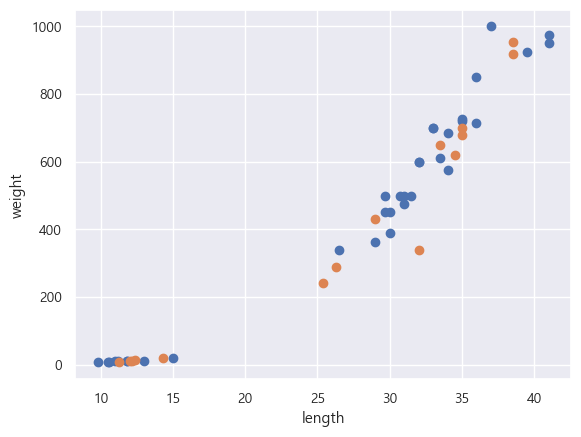

In [62]:
# 파란 점이 트레인셋, 주황 점이 테스트셋이다. 적절히 섞인 것을 확인할 수 있다.

plt.scatter(train_input[:,0], train_input[:,1])
plt.scatter(test_input[:,0], test_input[:,1])
plt.xlabel('length')
plt.ylabel('weight')

In [63]:
# 이제 만들었으니까 다시 한번 k-최근접이웃 뭐시기를 써보자.

In [78]:
kn.fit(train_input,train_target)

KNeighborsClassifier()

In [65]:
kn.score(test_input,test_target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



0.9333333333333333

In [66]:
kn.predict(test_input)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [67]:
# 데이터가 부족해서 그런가 약간 틀리는 모습 볼 수 있다.
kn.predict(test_input) == test_target

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True])

In [69]:
kn.predict([[25,150]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([0])

In [70]:
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


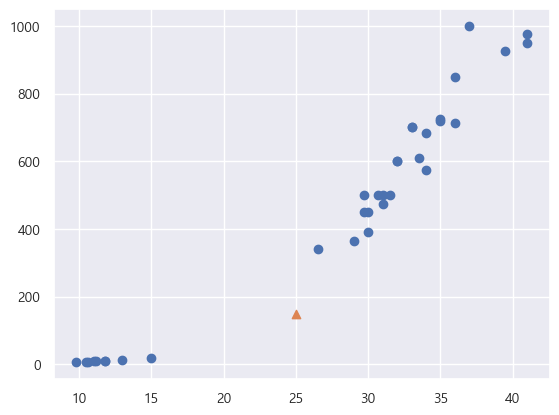

In [72]:
# 대체 왜 아래에 있는 삼각형 친구를 빙어에 더 가깝다고 하는가...?

plt.scatter(train_input[:,0],train_input[:,1])
plt.scatter(25,150, marker =  '^')

In [79]:
# 어떤 5개의 데이터를 참조했는지 확인해 보기 위해 kneighbors 를 사용한다.
# kneighbors 는 각각까지의 거리와 인덱스를 리턴해준다.
distances, indexes = kn.kneighbors([[25,150]])

In [80]:
kn.kneighbors([[25,150]])

(array([[130.48375378, 138.32150953, 140.62090883, 140.72046759,
         140.87753547]]),
 array([[19, 22, 29, 12, 27]], dtype=int64))

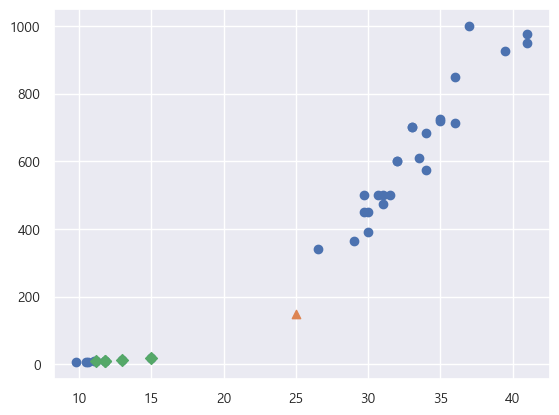

In [81]:
plt.scatter(train_input[:,0],train_input[:,1])
plt.scatter(25,150, marker =  '^')
plt.scatter(train_input[indexes, 0], train_input[indexes, 1], marker = 'D')

* 가까운건 위쪽 그룹에 가까워 보이는데, 왜 아래쪽 그룹이 가깝다고 할까?
* 스케일을 잘 보자.. 이미 많이 당했다.

In [82]:
# 초록색까지의 거리가 130, 140 이러는데 y 스케일을 보면 위로 가장 가까운 점도 200정도의 거리는 돼 보인다.
# x축 스케일을 y축과 동일하게 만들어 보자.
print(distances)

[[130.48375378 138.32150953 140.62090883 140.72046759 140.87753547]]


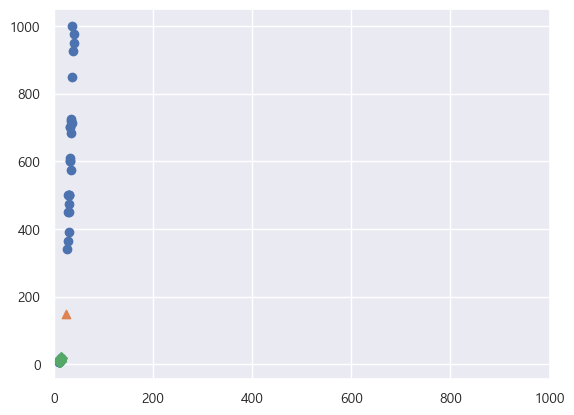

In [83]:
plt.scatter(train_input[:,0],train_input[:,1])
plt.scatter(25,150, marker =  '^')
plt.scatter(train_input[indexes, 0], train_input[indexes, 1], marker = 'D')
plt.xlim(0,1000)
plt.show()

* y축쪽으로 달라붙은 것이 보이고, 이제서야 컴퓨터가 어떻게 쟀는지 알 수 있다. 
* 이러한 문제는 두 특성의 스케일이 달라서 발생하는 것이다 .
* 이런 머신러닝 알고리즘은 샘플간 거리에 영향을 많이 받기 때문에 제대로 사용하기 위해서는 특성값을 일정한 기준으로 맞춰야 한다.
* 위와 같은 작업이 바로 ```데이터 전처리``` 다.
* 가장 많이 사용하는 전처리 방법 중 하나는 표준점수다.
* 표준점수는 각 특성값이 평균에서 표준편차의 몇배만큼 떨어져 있는지를 나타낸다.

In [84]:
# 넘파이는 평균과 표준편차 계산을 지원한다.

mean_fish = np.mean(train_input, axis = 0)
std_fish = np.std(train_input, axis = 0)

In [85]:
train_input

array([[  37. , 1000. ],
       [  35. ,  720. ],
       [  31.5,  500. ],
       [  41. ,  950. ],
       [  30.7,  500. ],
       [  30. ,  390. ],
       [  33. ,  700. ],
       [  36. ,  714. ],
       [  32. ,  600. ],
       [   9.8,    6.7],
       [  29. ,  363. ],
       [  35. ,  725. ],
       [  11.8,    9.9],
       [  10.5,    7.5],
       [  33.5,  610. ],
       [  31. ,  475. ],
       [  26.5,  340. ],
       [  29.7,  500. ],
       [  32. ,  600. ],
       [  15. ,   19.9],
       [  10.6,    7. ],
       [  36. ,  850. ],
       [  13. ,   12.2],
       [  41. ,  975. ],
       [  29.7,  450. ],
       [  33. ,  700. ],
       [  31. ,  500. ],
       [  11.2,    9.8],
       [  39.5,  925. ],
       [  11.8,   10. ],
       [  34. ,  575. ],
       [  34. ,  685. ],
       [  11. ,    9.7],
       [  30. ,  450. ]])

In [86]:
# 첫번째가 각각 특성의 평균값, 두번째가 각각 특성의 표준편차가 된다. 

print(mean_fish, std_fish)

[ 27.52352941 467.34411765] [ 10.0567817  319.10906783]


* 이제 평균과 표준편차가 구해졌으므로, 각 값들에서 평균값을 빼고 표준편차로 나눠 보자.
* 그러면 그것이 표준점수(z점수) 이다.

In [87]:
# 이것의 계산이 가능한 이유는 이들 각자가 넘파이어레이로 되어있기 때문이다. 이러한 것을 브로드캐스팅이라 한다.
# 근데 사실 브로드캐스팅의 정의가 뭐냐고 하면 잘 모를것같은디?

train_scaled = (train_input - mean_fish) / std_fish

In [88]:
# 이제서야 스케일링된 데이터를 얻어냈다.그러면 이것으로 훈련을 해 볼까?
train_scaled

array([[ 0.94229654,  1.66919695],
       [ 0.74342576,  0.791754  ],
       [ 0.3954019 ,  0.10233455],
       [ 1.34003809,  1.51251071],
       [ 0.31585359,  0.10233455],
       [ 0.24624882, -0.24237518],
       [ 0.54455498,  0.72907951],
       [ 0.84286115,  0.77295166],
       [ 0.44511959,  0.41570703],
       [-1.76234604, -1.4435319 ],
       [ 0.14681343, -0.32698575],
       [ 0.74342576,  0.80742263],
       [-1.56347526, -1.43350398],
       [-1.69274127, -1.44102492],
       [ 0.59427268,  0.44704428],
       [ 0.34568421,  0.02399143],
       [-0.10177505, -0.39906142],
       [ 0.2164182 ,  0.10233455],
       [ 0.44511959,  0.41570703],
       [-1.24528202, -1.40216673],
       [-1.68279773, -1.44259178],
       [ 0.84286115,  1.19913823],
       [-1.4441528 , -1.42629641],
       [ 1.34003809,  1.59085383],
       [ 0.2164182 , -0.05435169],
       [ 0.54455498,  0.72907951],
       [ 0.34568421,  0.10233455],
       [-1.6231365 , -1.43381735],
       [ 1.19088501,

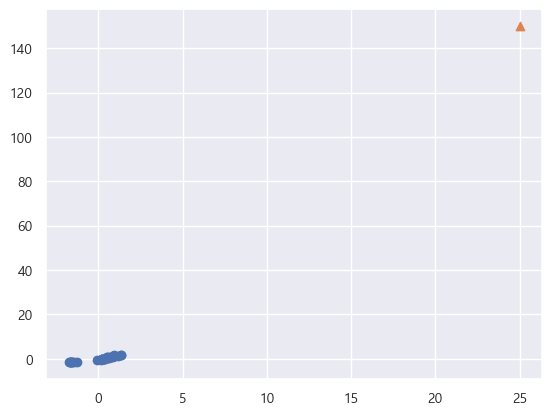

In [90]:
# 이렇게만 하면 당연히 이런식으로 나올 수 밖에 없다. 판단하고자 하는 샘플 역시도 스케일링을 해 줘야 한다. 

plt.scatter(train_scaled[:,0],train_scaled[:,1])
plt.scatter(25,150, marker =  '^')


plt.show()

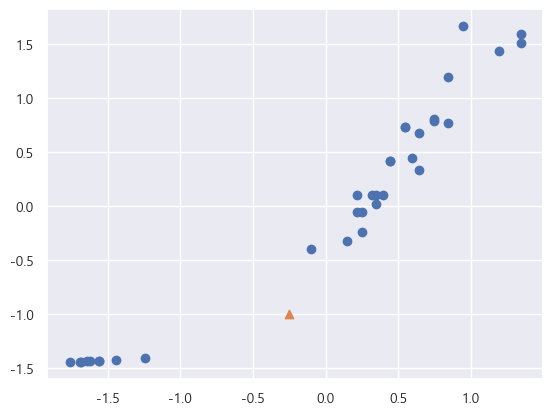

In [92]:
# 이제서야 각각 특성의 스케일이 같도록 만들어 줄 수 있었다. 그러면 이것으로 다시 모델을 만들어 보자. 

new = ([25,150]-mean_fish) /std_fish
plt.scatter(train_scaled[:,0],train_scaled[:,1])
plt.scatter(new[0],new[1], marker =  '^')
plt.show()

In [93]:
kn.fit(train_scaled, train_target)

KNeighborsClassifier()

In [94]:
# 이 과정을 빼먹으면 안된다. 테스트 할 때도 반드시 자료를 스케일링해주어야함을 잊지 말자.

test_scaled = (test_input - mean_fish) / std_fish

In [95]:
# 테스트를 돌렸을 때도 정확하게 분류해 냈음을 알 수 있다.
kn.score(test_scaled, test_target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



1.0

In [96]:
# 이제 아까 그 문제의 것을 넣었을 때 정상적으로 도미다! 라고 이야기해준다.

kn.predict([new])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



array([1])

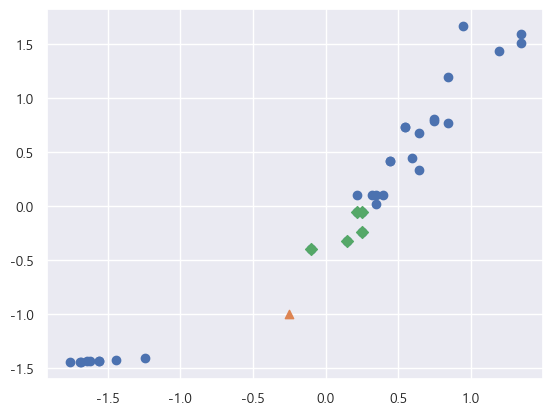

In [98]:
# 마지막으로 이것을 판단할 때 어떤 점을 참조했는지 확인해 보자.
distances, indexes = kn.kneighbors([new])
plt.scatter(train_scaled[:,0],train_scaled[:,1])
plt.scatter(new[0],new[1], marker =  '^')
plt.scatter(train_scaled[indexes, 0], train_scaled[indexes, 1], marker = 'D')

In [99]:
# 정상적으로 도미쪽을 가깝게 참조했음을 알 수 있다.

distances

array([[0.61380533, 0.7770022 , 0.90157098, 1.04987304, 1.06348753]])